In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Parameters
latent_dim = 2
batch_size = 128
epochs = 10
# Device selection with support for CUDA, MPS, and CPU

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")

# Data
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Encoder
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(1, 32, 4, 2, 1), # -> (32, 14, 14)
      nn.ReLU(),
      nn.Conv2d(32, 64, 4, 2, 1), # -> (64, 7, 7)
      nn.ReLU(),
      nn.Flatten()
    )
    self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
    self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
    
  def forward(self, x):
    x = self.conv(x)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu, logvar

# Decoder
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
    self.deconv = nn.Sequential(
      nn.ConvTranspose2d(64, 32, 4, 2, 1), # -> (32, 14, 14)
      nn.ReLU(),
      nn.ConvTranspose2d(32, 1, 4, 2, 1),  # -> (1, 28, 28)
      nn.Sigmoid()
    )
    
  def forward(self, z):
    x = self.fc(z)
    x = x.view(-1, 64, 7, 7)
    x = self.deconv(x)
    return x

# VAE Model
class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std
    
  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decoder(z)
    return x_hat, mu, logvar

# Loss function
def loss_fn(x_hat, x, mu, logvar):
  recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + kl_loss

# Initialize
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(epochs):
  model.train()
  train_loss = 0
  for x, _ in train_loader:
    x = x.to(device)
    x_hat, mu, logvar = model(x)
    loss = loss_fn(x_hat, x, mu, logvar)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()
    
  print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Using device: mps
Epoch 1, Loss: 195.7938
Epoch 2, Loss: 170.1042
Epoch 3, Loss: 164.8958
Epoch 4, Loss: 161.3645
Epoch 5, Loss: 159.2712
Epoch 6, Loss: 157.7949
Epoch 7, Loss: 156.7777
Epoch 8, Loss: 155.9212
Epoch 9, Loss: 155.2651
Epoch 10, Loss: 154.7446


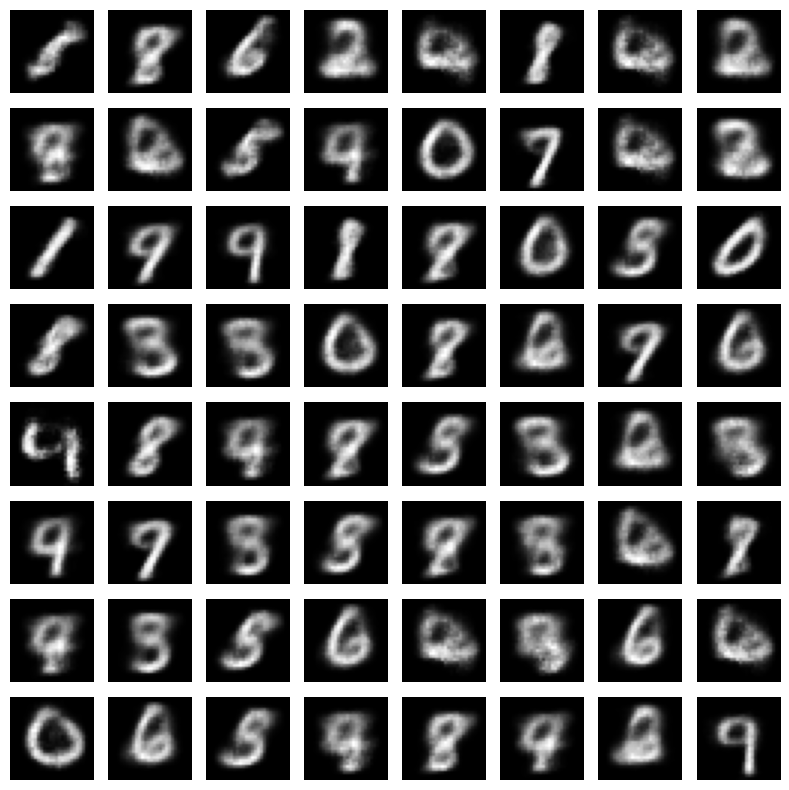

In [2]:
import matplotlib.pyplot as plt

# Sampling and visualizing
with torch.no_grad():
  z = torch.randn(64, latent_dim).to(device)
  samples = model.decoder(z).cpu()

# Plotting
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(samples[i][0], cmap='gray')
  ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
# Load test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

latents = []
labels = []

# Encode all test images
model.eval()
with torch.no_grad():
  for x, y in test_loader:
    x = x.to(device)
    mu, logvar = model.encoder(x)
    z = model.reparameterize(mu, logvar)
    latents.append(z.cpu())
    labels.append(y)

# Stack all
latents = torch.cat(latents, dim=0)
labels = torch.cat(labels, dim=0)


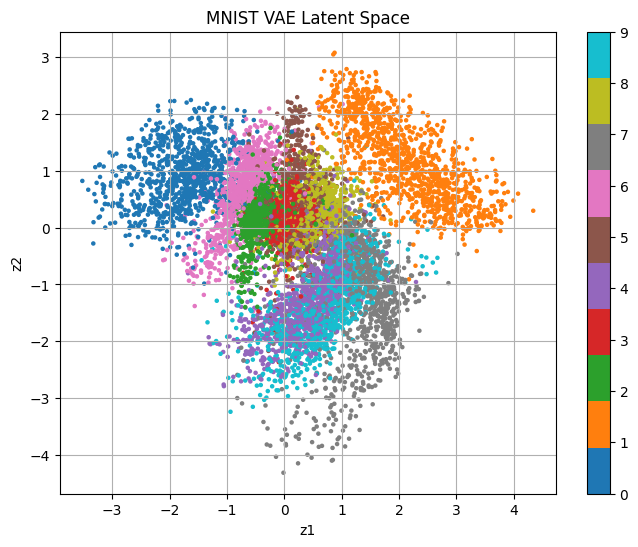

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('MNIST VAE Latent Space')
plt.xlabel('z1')
plt.ylabel('z2')
plt.grid(True)
plt.show()
